In [11]:
import os
import glob
import pandas as pd
import numpy as np
import zipfile
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt

# Settings for file structure
base_path = r"E:\EarthScienceFair_Data"
target_folders = ["1", "2", "3", "4"]  # 只處理 file 1-4


# Mass configuration (kg) - 用 dict 對應不同組別的質量
mass_dict = {
    "1-G2": 1.9505,   # w1: 1950.5g
    "1-G3": 2.0122,   # w2: 2012.2g
    "2-G1": 2.2201,   # w3: 2220.1g
    "2-G2": 2.6162,   # w4: 2616.2g
    "2-G3": 2.6162,   # w4: 2616.2g
    "2-G4": 2.6162,   # w4: 2616.2g
    "2-G5": 1.9495,   # h3: 1949.5g
    "3-G1": 1.9650,   # h1: 1965.0g
    "3-G2": 1.9531,   # h2: 1953.1g
    "4-G1": 1.8559,   # na: 1855.9g (對照組)
}

# 預設質量（如果某個組別不在 dict 中）
default_mass = 1.9000

def auto_trim_index(y, threshold_factor=3.0, window_size=20):
    """
    偵測數據開始劇烈波動的索引位置
    y: 數據數組
    threshold_factor: 偵測門檻（噪訊標準差的幾倍），若切太多可以調高此數值
    window_size: 滑動窗口大小
    """
    if len(y) < window_size:
        return 0
    
    # 以開頭一小段（前100點）計算基礎環境噪訊的標準差
    base_std = np.std(y[:min(100, len(y))])
    
    # 轉換成 pandas Series 計算滑動標準差
    y_series = pd.Series(y)
    rolling_std = y_series.rolling(window=window_size).std().fillna(0).values
    
    # 找到第一個顯著超過噪訊門檻的地方
    trigger_threshold = base_std * threshold_factor
    indices = np.where(rolling_std > trigger_threshold)[0]
    
    if len(indices) > 0:
        # 往前回溯一個窗口大小，確保包含完整的起跳波形
        return max(0, indices[0] - window_size)
    
    return 0

# 儲存所有實驗的原始數據，用於計算不確定度
# 結構: {G1: {rms_x: [...], rms_y: [...], ...}, G2: {...}, ...}
group_data = {}

results = []

def filter_outliers(data, threshold=0.1):
    """
    過濾異常值：若前一筆數據和後一筆數據落差超過 threshold，則標記為異常
    回傳清理後的資料索引
    """
    if len(data) <= 1:
        return np.ones(len(data), dtype=bool)
    
    valid_mask = np.ones(len(data), dtype=bool)
    
    for i in range(1, len(data)):
        if abs(data[i] - data[i-1]) > threshold:
            valid_mask[i] = False
    
    return valid_mask

def clean_side_data(side_data_raw, t_s_raw):
    """
    清理側面數據：與 t_s 同步對齊，插值缺失值
    
    參數:
        side_data_raw: 側面測量數據（ye, yd, yc, yb, ya）
        t_s_raw: 原始時間序列
    """
    # 找出 t_s 的有效索引
    time_series = pd.Series(t_s_raw)
    time_numeric = pd.to_numeric(time_series, errors='coerce')
    valid_time_mask = time_numeric.notna()
    
    # 對側面數據也套用相同的遮罩
    data_series = pd.Series(side_data_raw)
    numeric_series = pd.to_numeric(data_series, errors='coerce')
    
    # 只保留 t_s 有效的那些行
    aligned_series = numeric_series[valid_time_mask]
    
    # 插值處理（只在有效行範圍內）
    if aligned_series.isna().any():
        nan_count = aligned_series.isna().sum()
        total_count = len(aligned_series)
        print(f"    發現 {nan_count}/{total_count} 個空白值，進行插值...")
        
        aligned_series = aligned_series.interpolate(method='linear', limit_direction='both')
        aligned_series = aligned_series.ffill().bfill()
    
    # 取出有效值
    data_clean = aligned_series[aligned_series.notna()].values
    
    if len(data_clean) == 0:
        return np.array([])
    
    data_clean = data_clean.astype(float)
    
    # 過濾異常值 + 去中心化
    valid_mask = filter_outliers(data_clean, threshold=0.1)
    data_filtered = data_clean[valid_mask]
    
    if len(data_filtered) > 0:
        data_filtered = data_filtered - np.mean(data_filtered)
    
    return data_filtered


def clean_data_with_outlier_filter(data, time_data=False, allow_interpolation=True):
    """
    清理數據：移除非數值、插值填補空白、轉換型別、並過濾異常值
    （用於時間數據和俯瞰數據）
    """
    data_series = pd.Series(data)
    numeric_series = pd.to_numeric(data_series, errors='coerce')
    
    # 插值處理
    if allow_interpolation and numeric_series.isna().any():
        nan_count = numeric_series.isna().sum()
        total_count = len(numeric_series)
        print(f"    發現 {nan_count}/{total_count} 個空白值，進行插值...")
        
        numeric_series = numeric_series.interpolate(method='linear', limit_direction='both')
        numeric_series = numeric_series.ffill().bfill()
    
    # 取出有效值
    data_clean = numeric_series[numeric_series.notna()].values
    
    if len(data_clean) == 0:
        return np.array([])
    
    data_clean = data_clean.astype(float)
    
    if time_data:
        # 時間數據：歸零
        data_clean = data_clean - data_clean[0]
        return data_clean
    else:
        # 測量數據：過濾異常值 + 去中心化
        valid_mask = filter_outliers(data_clean, threshold=0.1)
        data_filtered = data_clean[valid_mask]
        
        if len(data_filtered) > 0:
            data_filtered = data_filtered - np.mean(data_filtered)
        return data_filtered

# Find all xlsx files in target folders only
xlsx_files = []
for folder in target_folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        xlsx_files.extend(glob.glob(os.path.join(folder_path, "**", "*.xlsx"), recursive=True))

print(f"找到 {len(xlsx_files)} 個 xlsx 檔案在 file 1-4 中\n")

for tracker_file in xlsx_files:
    print("處理:", tracker_file)
    
    # 提取實驗組別
    file_name = os.path.basename(tracker_file)
    parts = file_name.split('-')
    if len(parts) >= 2:
        folder_num = parts[0]
        group_name = parts[1]
        combined_key = f"{folder_num}-{group_name}"
    else:
        print("檔名格式不符，跳過")
        continue
    
    mass = mass_dict.get(combined_key, default_mass)
    print(f"  組別: {combined_key}, 質量: {mass} kg")
    
    try:
        df = pd.read_excel(tracker_file)
    except:
        print("讀取失敗:", tracker_file)
        continue

    # 讀取資料欄位
    t_s_raw = df.iloc[:, 0].values
    ye_raw = df.iloc[:, 1].values
    yd_raw = df.iloc[:, 2].values
    yc_raw = df.iloc[:, 3].values
    yb_raw = df.iloc[:, 4].values
    ya_raw = df.iloc[:, 5].values
    
    t_a_raw = df.iloc[:, -3].values
    x_raw = df.iloc[:, -2].values
    y_raw = df.iloc[:, -1].values

    # === 1. 處理時間與基礎清理 ===
    t_s = clean_data_with_outlier_filter(t_s_raw, time_data=True, allow_interpolation=False)
    t_a = clean_data_with_outlier_filter(t_a_raw, time_data=True, allow_interpolation=False)
    
    # === 2. 處理俯瞰數據 (使用中位數濾波 + 自動裁切) ===
    x_clean = clean_data_with_outlier_filter(x_raw, allow_interpolation=False)
    y_clean = clean_data_with_outlier_filter(y_raw, allow_interpolation=False)

    if len(y_clean) > 0:
        # 修復 16s 尖峰雜訊
        x_med = medfilt(x_clean, kernel_size=5)
        y_med = medfilt(y_clean, kernel_size=5)
        
        # 自動偵測開始動的時間點點 (排除 0~3s)
        start_idx = auto_trim_index(y_med)
        x = x_med[start_idx:]
        y = y_med[start_idx:]
    else:
        x, y = np.array([]), np.array([])

    # 計算 RMS
    rms_x = np.sqrt(np.mean(x**2)) if len(x) > 0 else np.nan
    rms_y = np.sqrt(np.mean(y**2)) if len(y) > 0 else np.nan
    ratio = rms_y / rms_x if (rms_x > 1e-8 and not np.isnan(rms_x)) else np.nan

    # === 3. 處理側面數據 (與俯瞰數據同步裁切) ===
    side_raw_data = {"ye": ye_raw, "yd": yd_raw, "yc": yc_raw, "yb": yb_raw, "ya": ya_raw}
    layers = {}
    
    for key, raw_val in side_raw_data.items():
        side_clean = clean_side_data(raw_val, t_s_raw)
        if len(side_clean) > 0:
            # 同樣經過濾波與同步裁切
            side_med = medfilt(side_clean, kernel_size=5)
            layers[key] = side_med[start_idx:] if len(side_med) > start_idx else side_med
        else:
            layers[key] = np.array([])

    # FFT 頻率分析
    main_freqs = []
    for key, y_layer in layers.items():
        if len(y_layer) < 2 or len(t_s) < 2:
            continue
            
        dt = np.mean(np.diff(t_s)) # 使用原始採樣間隔
        N = len(y_layer)
        yf = fft(y_layer)
        xf = fftfreq(N, dt)[:N//2]
        amplitude = 2.0/N * np.abs(yf[:N//2])
        
        # 關鍵：排除 0.5 Hz 以下的雜訊，抓真正的震動峰值
        freq_mask = xf > 0.5
        if np.any(freq_mask):
            peak_idx = np.argmax(amplitude[freq_mask])
            main_freq = xf[freq_mask][peak_idx]
            print(f"  {key} 主頻率: {main_freq:.2f} Hz")
            main_freqs.append(main_freq)
    
    if len(main_freqs) > 0:
        f_n = np.mean(main_freqs)
        print(f"  系統自然頻率: {f_n:.2f} Hz")
    else:
        f_n = np.nan
        print("  無法計算頻率")

    # 計算剛性
    k = mass * (2 * np.pi * f_n)**2 if not np.isnan(f_n) else np.nan

    # === 4. 讀取加速度資料 (保持原邏輯) ===
    folder = os.path.dirname(tracker_file)
    base_name = os.path.splitext(os.path.basename(tracker_file))[0]
    all_zips = glob.glob(os.path.join(folder, "*.zip"))
    zip_file = next((z for z in all_zips if os.path.splitext(os.path.basename(z))[0] == base_name), None)
    
    rms_acc = np.nan
    if zip_file:
        try:
            with zipfile.ZipFile(zip_file, 'r') as z:
                csv_files = [f for f in z.namelist() if f.endswith('.csv')]
                if csv_files:
                    with z.open(csv_files[0]) as f:
                        acc_df = pd.read_csv(f)
                        acc_abs_raw = acc_df.iloc[:, -1].values
                        acc_series = pd.to_numeric(pd.Series(acc_abs_raw), errors='coerce').dropna().values
                        if len(acc_series) > 0:
                            # 加速度同樣做一次異常過濾
                            acc_filtered = acc_series[filter_outliers(acc_series, threshold=0.1)]
                            rms_acc = np.sqrt(np.mean(acc_filtered**2)) if len(acc_filtered) > 0 else np.nan
        except Exception as e:
            print(f"  讀取 zip 錯誤: {e}")

    # 儲存結果與群組統計
    results.append([tracker_file, combined_key, rms_x, rms_y, ratio, f_n, k, rms_acc])
    
    if combined_key not in group_data:
        group_data[combined_key] = {p: [] for p in ['rms_x', 'rms_y', 'ratio', 'f_n', 'k', 'rms_acc']}
    
    for field, val in zip(['rms_x', 'rms_y', 'ratio', 'f_n', 'k', 'rms_acc'], 
                          [rms_x, rms_y, ratio, f_n, k, rms_acc]):
        group_data[combined_key][field].append(val)
    
    print(f"  已處理 {combined_key}")

# 建立結果 DataFrame
results_df = pd.DataFrame(results, columns=[
    "File", "Group", "RMS_x", "RMS_y", "偏心比例", "主頻率(Hz)", "等效剛性(N/m)", "RMS加速度"
])

# 計算每個群組的不確定度
uncertainty_results = []

for group_name, data in group_data.items():
    print(f"\n計算 {group_name} 的不確定度:")
    
    uncertainties = {}
    
    for param_name, values in data.items():
        # 移除 NaN 值
        valid_values = [v for v in values if not np.isnan(v)]
        
        if len(valid_values) >= 2:
            # 計算平均值
            mean_val = np.mean(valid_values)
            
            # 計算標準差 (樣本標準差，使用 n-1)
            std_val = np.std(valid_values, ddof=1)
            
            # 計算標準不確定度 (u = s / sqrt(n))
            n = len(valid_values)
            u_val = std_val / np.sqrt(n)
            
            # 計算相對不確定度 (%)
            relative_u = (u_val / mean_val * 100) if mean_val != 0 else np.nan
            
            uncertainties[param_name] = {
                'mean': mean_val,
                'std': std_val,
                'u': u_val,
                'relative_u': relative_u,
                'n': n
            }
            
            print(f"  {param_name}:")
            print(f"    平均值 = {mean_val:.6f}")
            print(f"    標準差 = {std_val:.6f}")
            print(f"    標準不確定度 u = {u_val:.6f}")
            print(f"    相對不確定度 = {relative_u:.2f}%")
            print(f"    樣本數 n = {n}")
        else:
            uncertainties[param_name] = {
                'mean': valid_values[0] if len(valid_values) == 1 else np.nan,
                'std': np.nan,
                'u': np.nan,
                'relative_u': np.nan,
                'n': len(valid_values)
            }
            print(f"  {param_name}: 樣本數不足 (n={len(valid_values)})")
    
    uncertainty_results.append({
        'Group': group_name,
        'RMS_x_mean': uncertainties['rms_x']['mean'],
        'RMS_x_u': uncertainties['rms_x']['u'],
        'RMS_y_mean': uncertainties['rms_y']['mean'],
        'RMS_y_u': uncertainties['rms_y']['u'],
        'ratio_mean': uncertainties['ratio']['mean'],
        'ratio_u': uncertainties['ratio']['u'],
        'f_n_mean': uncertainties['f_n']['mean'],
        'f_n_u': uncertainties['f_n']['u'],
        'k_mean': uncertainties['k']['mean'],
        'k_u': uncertainties['k']['u'],
        'rms_acc_mean': uncertainties['rms_acc']['mean'],
        'rms_acc_u': uncertainties['rms_acc']['u'],
        'sample_size': uncertainties['rms_x']['n']
    })

uncertainty_df = pd.DataFrame(uncertainty_results)

# 輸出結果
print("\n" + "="*80)
print("File 1-4 分析結果:")
print("="*80)
print(results_df)

print("\n" + "="*80)
print("各組不確定度統計:")
print("="*80)
print(uncertainty_df)

# 存檔
results_df.to_csv("analysis_results_file1to4.csv", index=False, encoding='utf-8-sig')
uncertainty_df.to_csv("uncertainty_file1to4.csv", index=False, encoding='utf-8-sig')

print("\n結果已儲存至:")
print("  - analysis_results_file1to4.csv (詳細結果)")
print("  - uncertainty_file1to4.csv (不確定度統計)")

找到 14 個 xlsx 檔案在 file 1-4 中

處理: E:\EarthScienceFair_Data\1\G2\1-G2-1.xlsx
  組別: 1-G2, 質量: 1.9505 kg
  ye 主頻率: 1.27 Hz
  yd 主頻率: 2.07 Hz
  yc 主頻率: 2.07 Hz
  yb 主頻率: 0.63 Hz
  ya 主頻率: 2.07 Hz
  系統自然頻率: 1.62 Hz
  已處理 1-G2
處理: E:\EarthScienceFair_Data\1\G2\1-G2-2.xlsx
  組別: 1-G2, 質量: 1.9505 kg
    發現 2/711 個空白值，進行插值...
  ye 主頻率: 2.07 Hz
  yd 主頻率: 2.07 Hz
  yc 主頻率: 2.07 Hz
  yb 主頻率: 0.63 Hz
  ya 主頻率: 2.07 Hz
  系統自然頻率: 1.78 Hz
  已處理 1-G2
處理: E:\EarthScienceFair_Data\1\G2\1-G2-3.xlsx
  組別: 1-G2, 質量: 1.9505 kg
    發現 1/663 個空白值，進行插值...
    發現 1/663 個空白值，進行插值...
  ye 主頻率: 0.86 Hz
  yd 主頻率: 0.86 Hz
  yc 主頻率: 0.86 Hz
  yb 主頻率: 0.86 Hz
  ya 主頻率: 0.86 Hz
  系統自然頻率: 0.86 Hz
  已處理 1-G2
處理: E:\EarthScienceFair_Data\1\G2\1-G2-4.xlsx
  組別: 1-G2, 質量: 1.9505 kg
    發現 2/712 個空白值，進行插值...
    發現 2/712 個空白值，進行插值...
  ye 主頻率: 0.79 Hz
  yd 主頻率: 0.79 Hz
  yc 主頻率: 0.80 Hz
  yb 主頻率: 2.00 Hz
  ya 主頻率: 1.40 Hz
  系統自然頻率: 1.15 Hz
  已處理 1-G2
處理: E:\EarthScienceFair_Data\1\G2\1-G2-5.xlsx
  組別: 1-G2, 質量: 1.9505 kg
  ye 

成功讀取數據！數據長度: 789, 平均 dt: 0.0333 s
診斷失敗，錯誤訊息：x and y must have same first dimension, but have shapes (786,) and (789,)
成功讀取數據！數據長度: 789, 平均 dt: 0.0333 s
診斷失敗，錯誤訊息：x and y must have same first dimension, but have shapes (786,) and (789,)


Traceback (most recent call last):
  File "C:\Users\miyun\AppData\Local\Temp\ipykernel_5672\3631247998.py", line 61, in diagnostic_plot
    plt.plot(t_s, ya_mean_removed, label='Original (Mean Removed)', color='gray', alpha=0.5)
  File "c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\pyplot.py", line 3838, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueErro

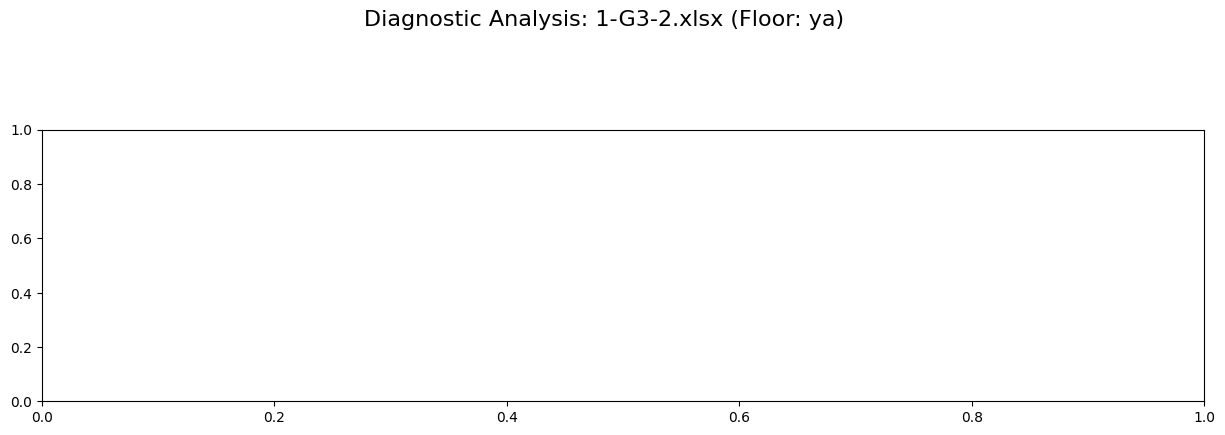

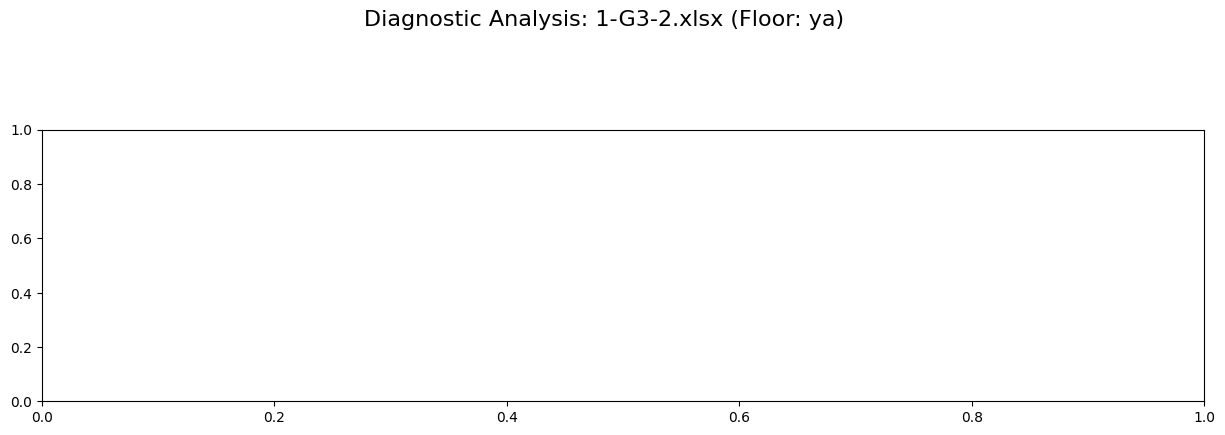

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt

# 設定目標檔案
target_file = "E:/EarthScienceFair_Data/1/G3/1-G3-2.xlsx"

def diagnostic_plot(file_path):
    try:
        df = pd.read_excel(file_path, header=None)
        
        # 1. 統一抓取第 4 列以後的數據
        data_block = df.iloc[3:].copy()
        # 強制轉成數字，不行的變 NaN
        data_block[0] = pd.to_numeric(data_block[0], errors='coerce')
        data_block[5] = pd.to_numeric(data_block[5], errors='coerce')
        # 同時刪除任一欄有空值的列，確保兩者長度絕對相等
        data_block = data_block.dropna(subset=[0, 5])
        
        t_s_raw = data_block[0].values
        ya_raw = data_block[5].values
        
        if len(t_s_raw) < 10:
            print("數據太短！")
            return

        # 2. 基礎處理
        t_s = t_s_raw - t_s_raw[0]
        dt = np.mean(np.diff(t_s))
        ya_mean_removed = ya_raw - np.mean(ya_raw)
        ya_med = medfilt(ya_mean_removed, kernel_size=5)
        
        # 3. 偵測裁切點
        start_idx = auto_trim_index(ya_med)
        
        # 4. 準備繪圖數據 (確保長度一致)
        # ya_med 的長度現在保證等於 t_s 的長度
        ya_trimmed = ya_med[start_idx:]
        t_trimmed = t_s[start_idx:]
        
        # 5. FFT
        N = len(ya_trimmed)
        yf = fft(ya_trimmed)
        xf = fftfreq(N, dt)[:N//2]
        amplitude = 2.0/N * np.abs(yf[:N//2])

        # --- 繪圖區 ---
        plt.figure(figsize=(15, 12))
        
        # 圖一
        plt.subplot(3, 1, 1)
        # 使用 len(t_s) 確保 x, y 長度一致
        plt.plot(t_s[:len(ya_med)], ya_med, label='Filtered Waveform', color='blue')
        plt.axvline(x=t_s[start_idx], color='red', linestyle='--', label='Auto-Trim Start')
        plt.title(f"Time Domain: Full Waveform (ya) - {os.path.basename(file_path)}")
        plt.legend()

        # 圖二
        plt.subplot(3, 1, 2)
        plt.plot(t_trimmed, ya_trimmed, color='green')
        plt.axhline(y=0, color='black', alpha=0.3)
        plt.title(f"Trimmed Zone (For RMS) - Final RMS: {np.sqrt(np.mean(ya_trimmed**2)):.6f}")

        # 圖三
        plt.subplot(3, 1, 3)
        plt.plot(xf, amplitude, color='red')
        plt.xlim(0.1, 10) # 避開 0 Hz 的無窮大
        # 標註你提到的 0.76Hz 和 2.5Hz
        plt.axvline(x=0.76, color='orange', linestyle=':', label='Bug Peak?')
        plt.axvline(x=2.5, color='purple', linestyle=':', label='Real Peak?')
        plt.title("Frequency Domain: FFT Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        import traceback
        traceback.print_exc()

diagnostic_plot(target_file)

Above code were provided by Claude and fixed by human.